Epoch [1/5], Loss: 0.3239
Validation Loss: 0.2408, Accuracy: 90.83%
Epoch [2/5], Loss: 0.2286
Validation Loss: 0.2437, Accuracy: 90.88%
Epoch [3/5], Loss: 0.2180
Validation Loss: 0.2140, Accuracy: 92.64%
Epoch [4/5], Loss: 0.2020
Validation Loss: 0.1980, Accuracy: 92.34%
Epoch [5/5], Loss: 0.1774
Validation Loss: 0.1779, Accuracy: 93.45%


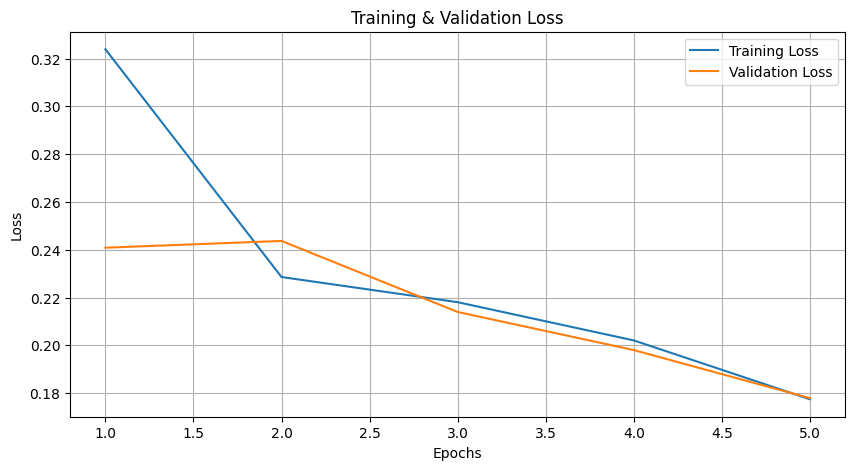

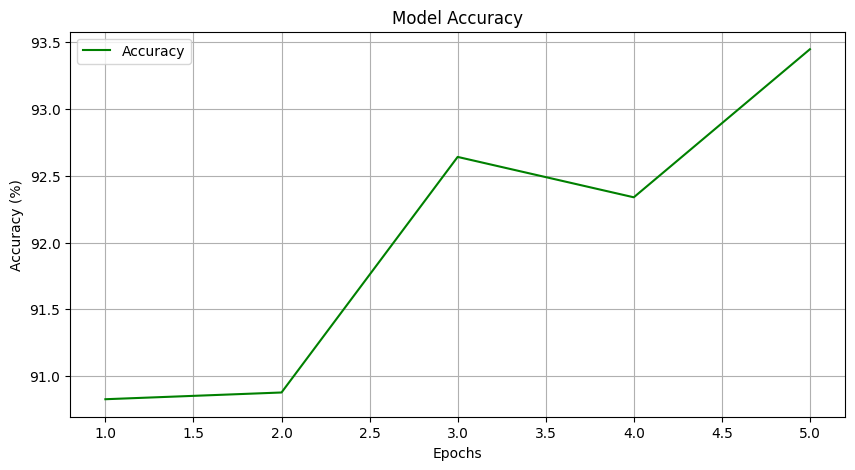

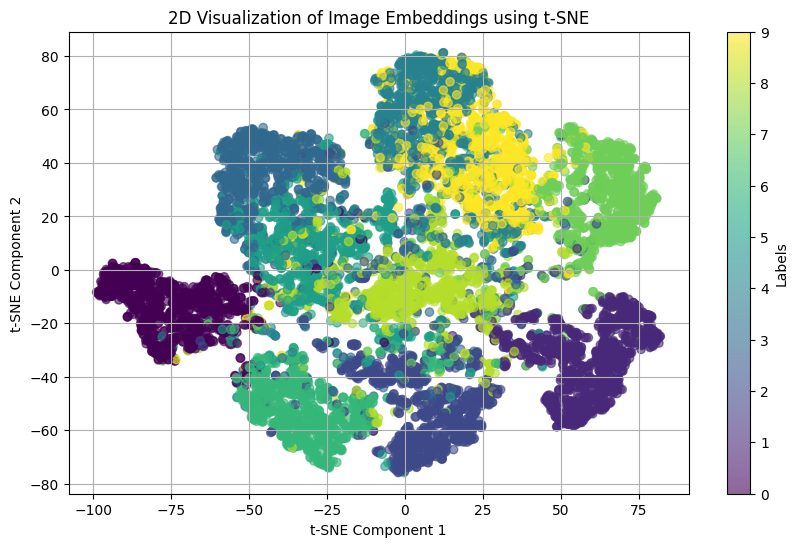

In [3]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

batch_size = 64
learning_rate = 0.001
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
usps_trainset = datasets.USPS(root='./data', train=True, download=True, transform=transform)
usps_testset = datasets.USPS(root='./data', train=False, download=True, transform=transform)

mnist_train_loader = DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, drop_last=True)
usps_train_loader = DataLoader(usps_trainset, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_test_loader = DataLoader(mnist_testset, batch_size=batch_size, shuffle=False, drop_last=True)
usps_test_loader = DataLoader(usps_testset, batch_size=batch_size, shuffle=False, drop_last=True)

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        self.fc_out = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward_once(self, x):
        x = x.view(x.size(0), -1)
        return self.feature_extractor(x)

    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        diff = torch.abs(out1 - out2)
        return self.fc_out(diff)


def train_siamese_model(model, mnist_loader, usps_loader, criterion, optimizer, num_epochs):
    model.train()
    train_losses = []
    val_losses = []
    accuracies = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        min_batches = min(len(mnist_loader), len(usps_loader))

        # Iterate with the loaders in sync
        for i, ((mnist_data, mnist_labels), (usps_data, usps_labels)) in enumerate(zip(mnist_loader, usps_loader)):
            if mnist_data.size(0) != usps_data.size(0):
                continue
            labels = (mnist_labels == usps_labels).float().unsqueeze(1).to(device)
            mnist_data, usps_data = mnist_data.to(device), usps_data.to(device)

            outputs = model(mnist_data, usps_data)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_train_loss = epoch_loss / min_batches
        train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

        avg_val_loss, accuracy = validate_siamese_model(model, mnist_test_loader, usps_test_loader, criterion)
        val_losses.append(avg_val_loss)
        accuracies.append(accuracy)

    return train_losses, val_losses, accuracies

def validate_siamese_model(model, mnist_loader, usps_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    min_batches = min(len(mnist_loader), len(usps_loader))
    with torch.no_grad():
        for i, ((mnist_data, mnist_labels), (usps_data, usps_labels)) in enumerate(zip(mnist_loader, usps_loader)):
            if mnist_data.size(0) != usps_data.size(0):
                continue

            labels = (mnist_labels == usps_labels).float().unsqueeze(1).to(device)
            mnist_data, usps_data = mnist_data.to(device), usps_data.to(device)

            outputs = model(mnist_data, usps_data)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_loss / min_batches
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return avg_val_loss, accuracy

model = SiameseNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses, accuracies = train_siamese_model(model, mnist_train_loader, usps_train_loader, criterion, optimizer, num_epochs)

epochs = range(1, len(train_losses) + 1)

import os

# Check if 'plots' directory exists; if not, create it
if not os.path.exists('plots'):
    os.makedirs('plots')

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig('plots/T&VLOSS.png')  # Now this will work
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracies, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('plots/Accuracy.png')  # This will also work
plt.show()


embeddings = []
labels = []

for images, label in mnist_test_loader:
    images = images.to(device)
    with torch.no_grad():
        emb = model.forward_once(images)
        embeddings.append(emb.cpu().numpy())
        labels.append(label.numpy())

embeddings = np.concatenate(embeddings, axis=0)
labels = np.concatenate(labels, axis=0)

tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Labels')
plt.title('2D Visualization of Image Embeddings using t-SNE')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()
plt.savefig('plots/embedding_plot.png')

plt.show()
